In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gpytorch
# from voltron.robinhood_utils import GetStockData
import os
# import robin_stocks.robinhood as r
import pickle5 as pickle
import pandas as pd
from torch.distributions import Beta
from scipy.special import betainc

sns.set_style('white')
# style.use('whitegrid')
palette = ["#1b4079", "#C6DDF0", "#048A81", "#B9E28C", "#8C2155", "#AF7595", "#E6480F", "#FA9500"]
sns.set(palette = palette, font_scale=2.0, style="white", rc={"lines.linewidth": 4.0})

In [2]:
sns.palplot(palette)

In [60]:
XLF_tckrs = list(pd.read_pickle("../../spdr-data/XLF.pkl").symbol.unique())
XLE_tckrs = list(pd.read_pickle("../../spdr-data/XLE.pkl").symbol.unique())

In [144]:
print(XLF_tckrs[:6])
print(XLE_tckrs)

['BRK.B', 'JPM', 'BAC', 'WFC', 'C', 'MS']
['XOM', 'CVX', 'EOG', 'COP', 'SLB']


In [256]:
spdrs = ["XLF", "XLE", "XLRE"]
tckr_spdrs = []
tckrs = []
for spdr in spdrs:
    spdr_dat = pd.read_pickle("../../spdr-data/" + spdr + ".pkl")
    syms = list(spdr_dat.symbol.unique())
    tckrs += syms
    tckr_spdrs += [spdr for _ in range(len(syms))]

In [124]:
SPDR = "XLE"
tckr = "CVX"

spdr_dat = pd.read_pickle("../../spdr-data/" + SPDR + ".pkl")    
data = spdr_dat[spdr_dat["symbol"] == tckr]
T = 5.
ts = torch.linspace(0, T, data.shape[0])
y = torch.FloatTensor(data['close_price'].to_numpy())

In [223]:
eval_times = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]

In [126]:
 prices_at_time_y = y[torch.tensor(eval_times)]
delta_y = prices_at_time_y[1:] - prices_at_time_y[:-1]

## Load Price Probabilities

In [127]:
voltron = torch.load("./outputs/voltron_" + tckr + ".pt")
matern = torch.load("./outputs/matern_" + tckr + ".pt")
specmix = torch.load("./outputs/sm_" + tckr + ".pt")

Example Beta(17, 8) which is pretty right skewed.

In [128]:
bought_func = lambda xs: betainc(17, 8, xs)
held_voltron = 1000 * bought_func(voltron)
held_matern = 1000 * bought_func(matern)
held_specmix = 1000 * bought_func(specmix)

In [129]:
def reward_risk(a, b, prob_incs):
    bought_func = lambda xs: betainc(a, b, xs)
    total_held = 1000 * bought_func(prob_incs)
    
    returns = total_held[1:] * delta_y
    #cum_returns = returns.cumsum(0)
    return returns.std(), returns.sum()

Randomly sample to find pareto fronts. ideally, we'd do BO or something like that but it's 2d.

In [130]:
base = 10000

In [131]:
prices_at_time_y = torch.tensor([y[0], *prices_at_time_y])

In [132]:
def value_func(vec, base = 10000):
    portfolio_value = torch.zeros(12)
    portfolio_value[0] = base
    for i in range(11):
        price_of_stock = portfolio_value[i] * bought_func(vec)[i]
        amt_bought = price_of_stock / prices_at_time_y[i]
        cash_left = portfolio_value[i] - price_of_stock
        portfolio_value[i+1] = cash_left + amt_bought * prices_at_time_y[i+1]
    return portfolio_value
    

In [133]:
plt_times = torch.tensor(eval_times) / 252
hodl_strat = 10000 / y[0] * prices_at_time_y[1:]

In [134]:
def running_sharpe_ratio(vec):
    returns = vec - 10000
    std_returns = torch.tensor([returns[:i].std(0) for i in range(len(vec))])
    # need avg return divided by sd of returns?
    return returns.cumsum(0) / std_returns / torch.arange(vec.shape[0])

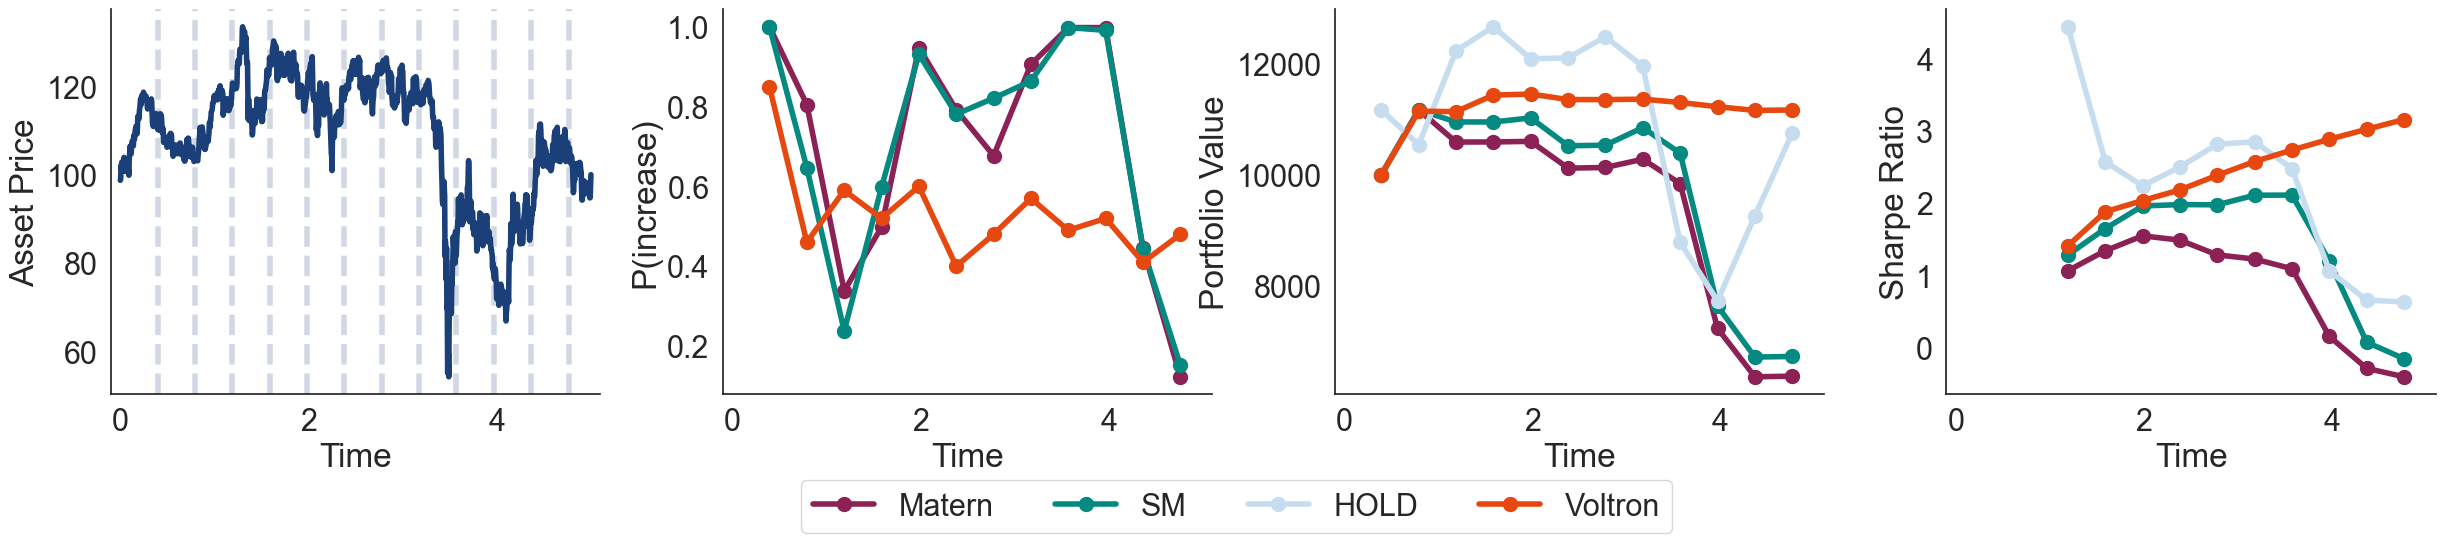

In [135]:
fig, ax = plt.subplots(1, 4, figsize = (30, 5))
ax[0].plot(ts, y)
[ax[i].set_xlabel("Time") for i in range(4)]
ax[0].set_ylabel("Asset Price")
[ax[0].axvline(x=plt_times[i], alpha = 0.2, linestyle="--") for i in range(len(eval_times))]

ax[1].plot(plt_times, matern, marker = ".", markersize = 20, label = "Matern", color=palette[4])
ax[1].plot(plt_times, specmix, marker = ".", markersize = 20, label = "Spectral Mixture", color=palette[2])
ax[1].plot(plt_times, voltron, marker = ".", markersize = 20, label = "Voltron", color = palette[-2])

ax[2].plot(plt_times, value_func(matern), label = "Matern", marker = ".", markersize = 20, color=palette[4])
ax[2].plot(plt_times, value_func(specmix), label = "SM", marker = ".", markersize = 20, color=palette[2])
ax[2].plot(plt_times, hodl_strat, label = "HOLD", marker = ".", markersize = 20, color=palette[1])
ax[2].plot(plt_times, value_func(voltron), label = "Voltron", marker = ".", markersize = 20, color = palette[-2])

ax[3].plot(plt_times, running_sharpe_ratio(value_func(matern)), 
           label = "Matern", marker = ".", markersize = 20, color=palette[4])
ax[3].plot(plt_times, running_sharpe_ratio(value_func(specmix)), 
           label = "SM", marker = ".", markersize = 20, color=palette[2])
ax[3].plot(plt_times, running_sharpe_ratio(hodl_strat), label = "HODL", marker = ".", markersize = 20,
          color=palette[1])
ax[3].plot(plt_times, running_sharpe_ratio(value_func(voltron)), 
           label = "Voltron", marker = ".", markersize = 20, color = palette[-2])

ax[1].set_ylabel("P(increase)")
ax[2].set_ylabel("Portfolio Value")
ax[3].set_ylabel("Sharpe Ratio")

ax[2].legend(ncol = 4, loc = "lower center", bbox_to_anchor = (-0.2, -0.4))
plt.subplots_adjust(wspace=0.25)
sns.despine()
[ax[i].set_xlim((-0.1, 5.1)) for i in range(4)]
plt.show()
# plt.savefig("trading_strategy.pdf", bbox_inches = "tight")

In [136]:
ts.max()

tensor(5.)

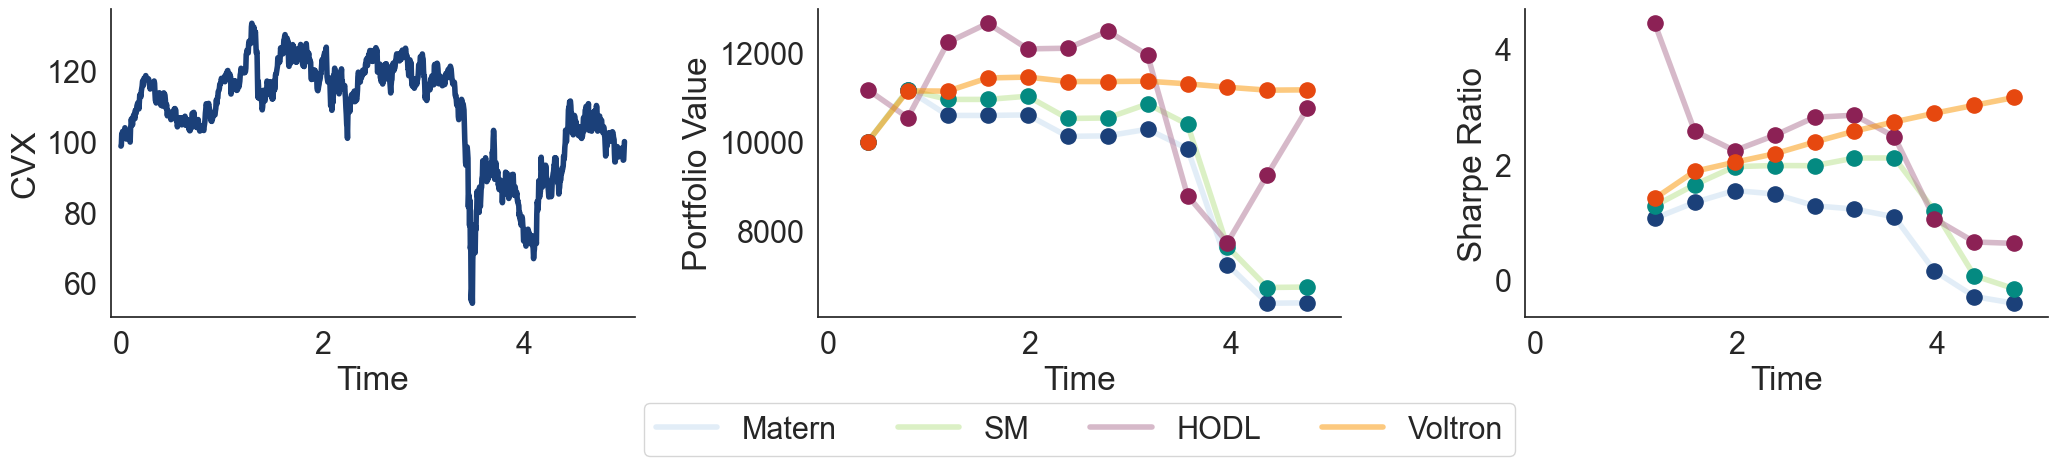

In [166]:

fig, ax = plt.subplots(1, 3, figsize = (25, 4))
ax[0].plot(ts, y)
[ax[i].set_xlabel("Time") for i in range(3)]
ax[0].set_ylabel(tckr)
[ax[0].axvline(x=eval_times[i], alpha = 0.2, linestyle="--") for i in range(len(eval_times))]

# ax[1].plot(plt_times, matern, label = "Matern", color=palette[1], alpha = 0.5)
# ax[1].plot(plt_times, specmix, label = "Spectral Mixture", color=palette[3], alpha = 0.5)
# ax[1].plot(plt_times, voltron, label = "Voltron", color = palette[-1], alpha = 0.5)
# ax[1].scatter(plt_times, matern, s = 120, label = "Matern", color=palette[0], zorder=4)
# ax[1].scatter(plt_times, specmix, s = 120, label = "Spectral Mixture", color=palette[2], zorder=4)
# ax[1].scatter(plt_times, voltron, s = 120, label = "Voltron", color = palette[-2], zorder=4)

ax[1].plot(plt_times, value_func(matern), label = "Matern", color=palette[1], alpha = 0.5)
ax[1].plot(plt_times, value_func(specmix), label = "SM", color=palette[3], alpha = 0.5)
ax[1].plot(plt_times, hodl_strat, label = "Hold", color=palette[5], alpha = 0.5)
ax[1].plot(plt_times, value_func(voltron), label = "Voltron", color = palette[-1], alpha = 0.5)
ax[1].scatter(plt_times, value_func(matern), color=palette[0], zorder=4, s=120)
ax[1].scatter(plt_times, value_func(specmix), color=palette[2], zorder=4, s=120)
ax[1].scatter(plt_times, hodl_strat,color=palette[4], zorder=4, s=120)
ax[1].scatter(plt_times, value_func(voltron),color = palette[-2], zorder=4, s=120)

ax[2].plot(plt_times, running_sharpe_ratio(value_func(matern)), 
       label = "Matern", color=palette[1], alpha = 0.5)
ax[2].plot(plt_times, running_sharpe_ratio(value_func(specmix)), 
           label = "SM", color=palette[3], alpha = 0.5)
ax[2].plot(plt_times, running_sharpe_ratio(hodl_strat), label = "HODL", markersize = 20,
          color=palette[5], alpha = 0.5)
ax[2].plot(plt_times, running_sharpe_ratio(value_func(voltron)), 
           label = "Voltron", color = palette[-1], alpha = 0.5)
ax[2].scatter(plt_times, running_sharpe_ratio(value_func(matern)), 
           s = 120, color=palette[0], zorder=4)
ax[2].scatter(plt_times, running_sharpe_ratio(value_func(specmix)), 
           s = 120, color=palette[2], zorder=4)
ax[2].scatter(plt_times, running_sharpe_ratio(hodl_strat),
             s = 120, color = palette[4], zorder=4)
ax[2].scatter(plt_times, running_sharpe_ratio(value_func(voltron)), 
           s = 120, color = palette[-2], zorder=4)


# ax[1].set_ylabel("P(increase)")
ax[1].set_ylabel("Portfolio Value")
ax[2].set_ylabel("Sharpe Ratio")

ax[2].legend(ncol = 4, loc = "lower center", bbox_to_anchor = (-0.85, -0.5))
plt.subplots_adjust(wspace=0.35)
sns.despine()
[ax[i].set_xlim((-0.1, 5.1)) for i in range(3)]
# plt.savefig("trading_strategy_" + tckr + ".pdf", bbox_inches = "tight")
plt.show()

## Do everything

In [275]:
tckrs = ["BAC", "BRK.B", "CVX", "EOG", "JPM", "XOM", "WFC", "COP", "C", "SLB"]
spdrs = ["XLF", "XLF", "XLE", "XLE", "XLF", "XLE", "XLF", "XLE", "XLF", "XLE"]


def running_sharpe_ratio(vec):
    returns = (vec - 10000)
    std_returns = torch.tensor([returns[:i].std(0) for i in range(len(vec))])
    # need avg return divided by sd of returns?
    return returns.cumsum(0) / std_returns / torch.arange(vec.shape[0])

def reward_risk(a, b, prob_incs):
    bought_func = lambda xs: betainc(a, b, xs)
    total_held = 1000 * bought_func(prob_incs)
    
    returns = total_held[1:] * delta_y
    #cum_returns = returns.cumsum(0)
    return returns.std(), returns.sum()

def value_func(vec, base = 10000):
    portfolio_value = torch.zeros(12)
    portfolio_value[0] = base
    for i in range(11):
        price_of_stock = portfolio_value[i] * bought_func(vec)[i]
        amt_bought = price_of_stock / prices_at_time_y[i]
        cash_left = portfolio_value[i] - price_of_stock
        portfolio_value[i+1] = cash_left + amt_bought * prices_at_time_y[i+1]
    return portfolio_value

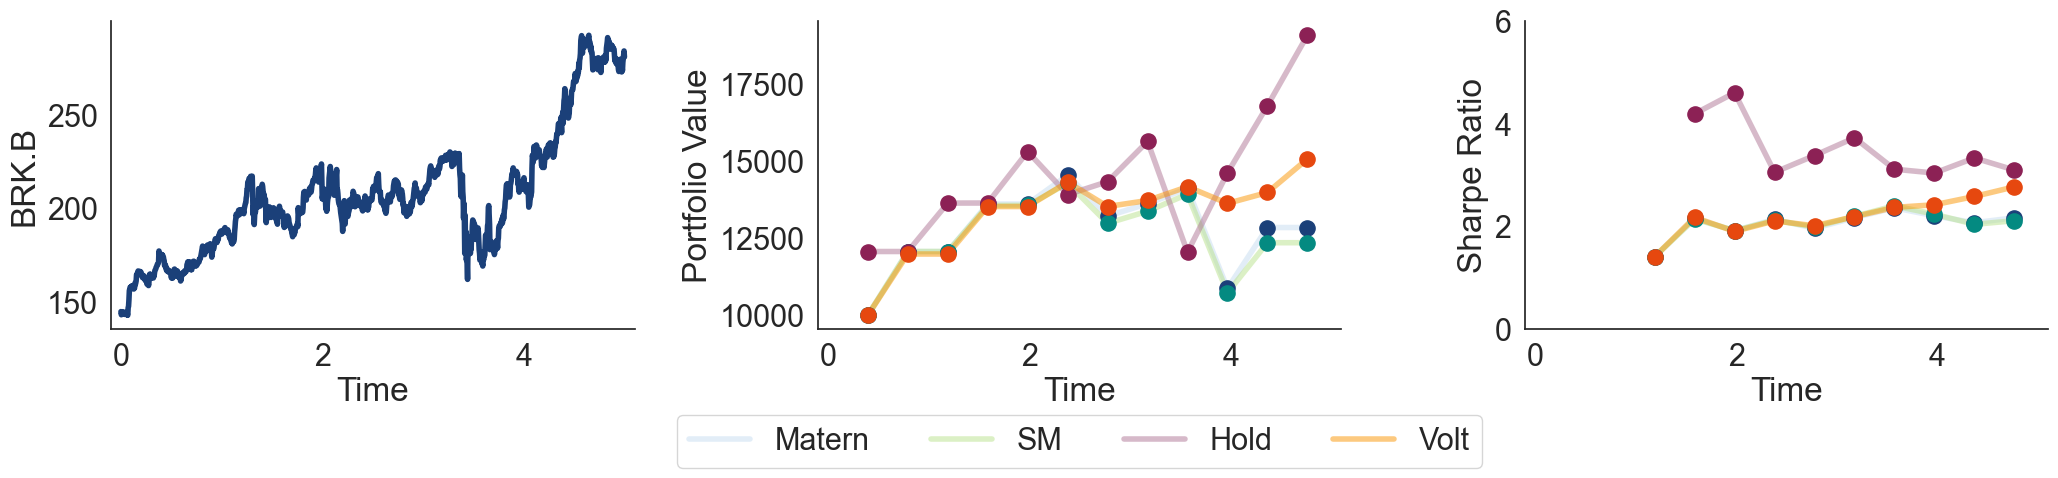

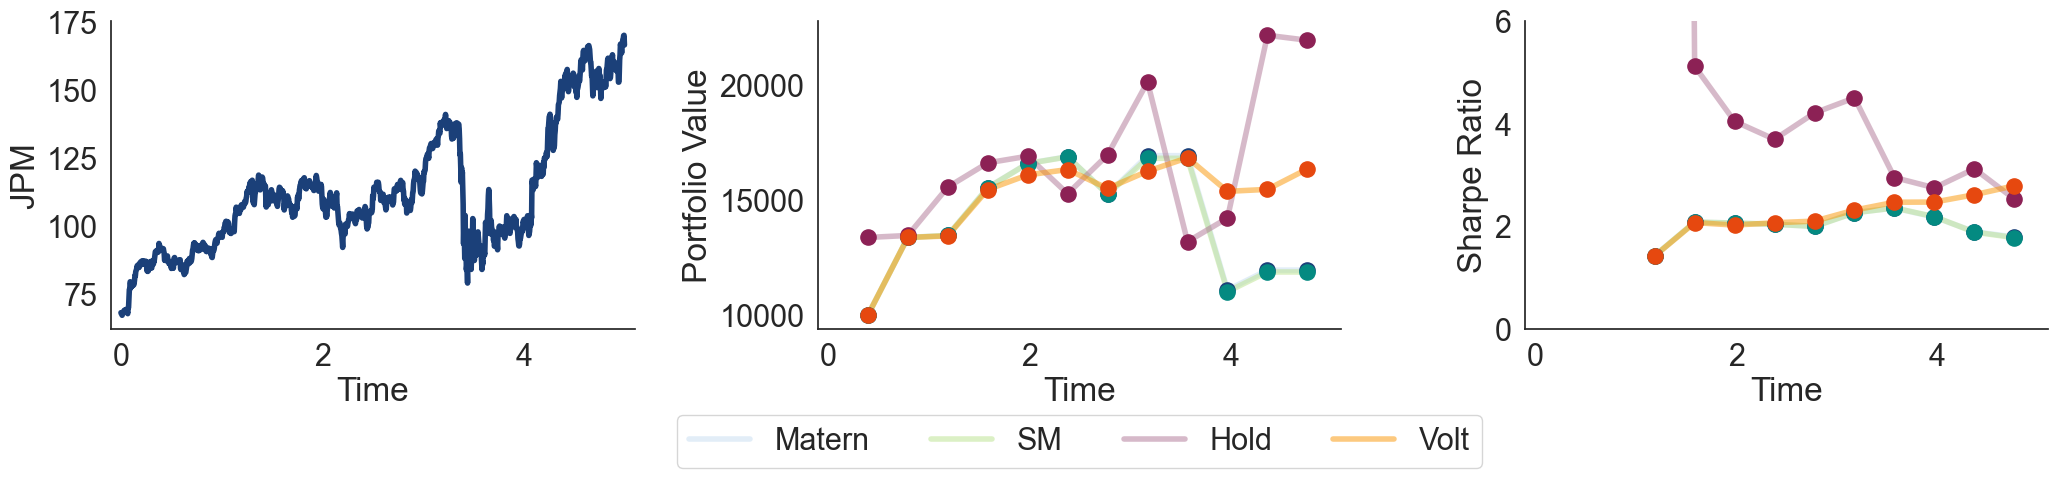

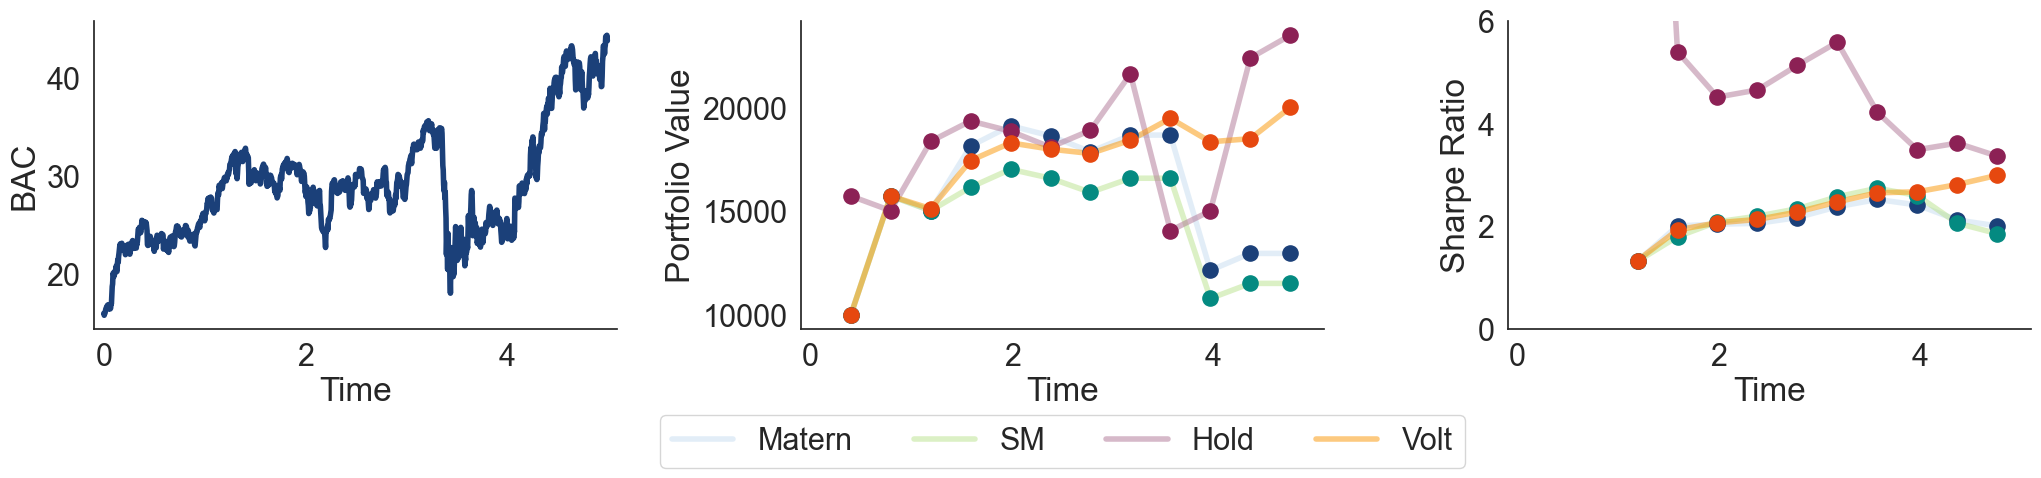

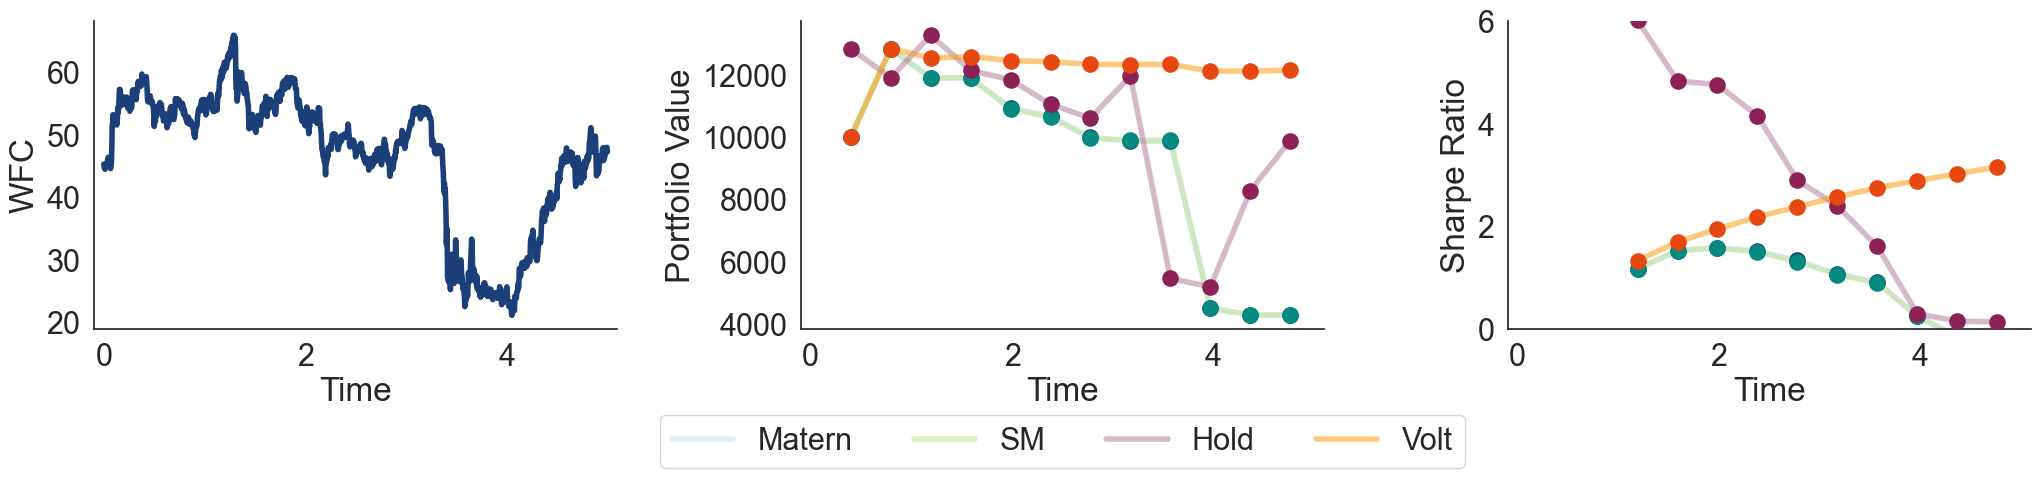

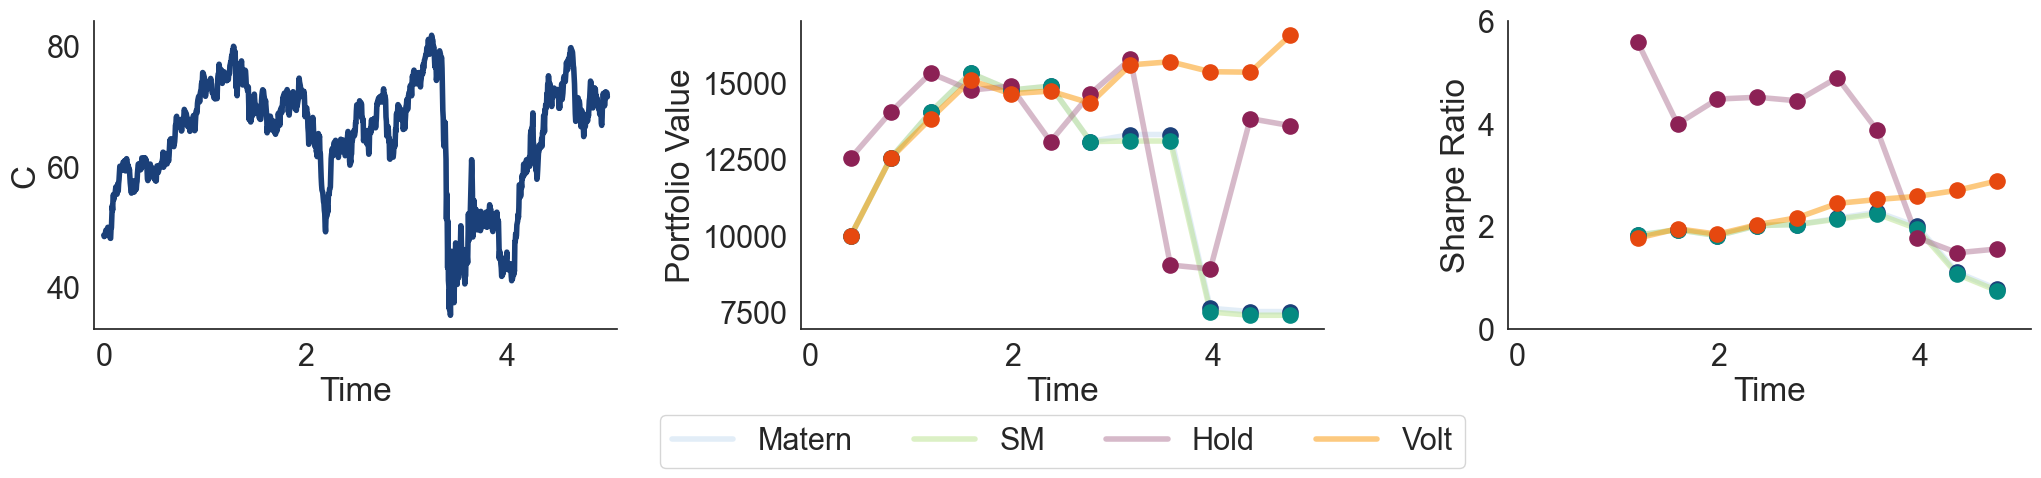

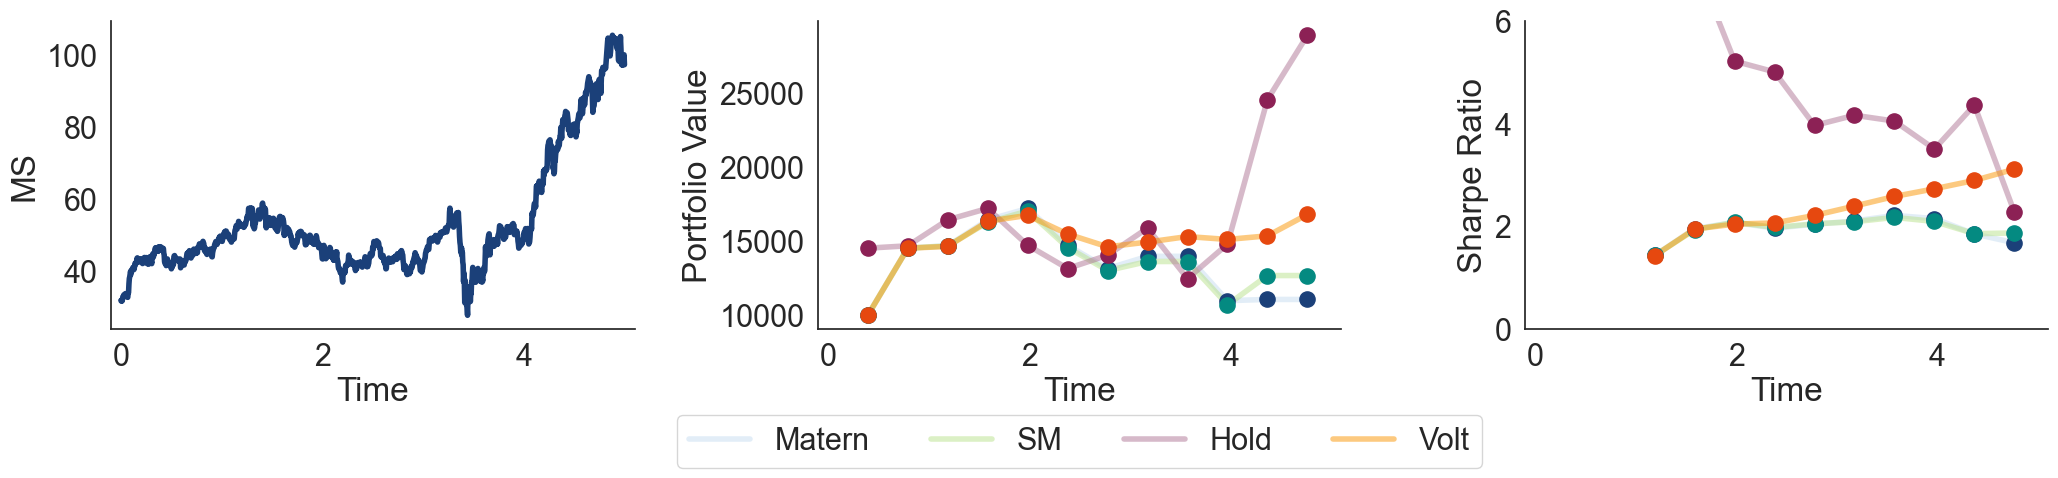

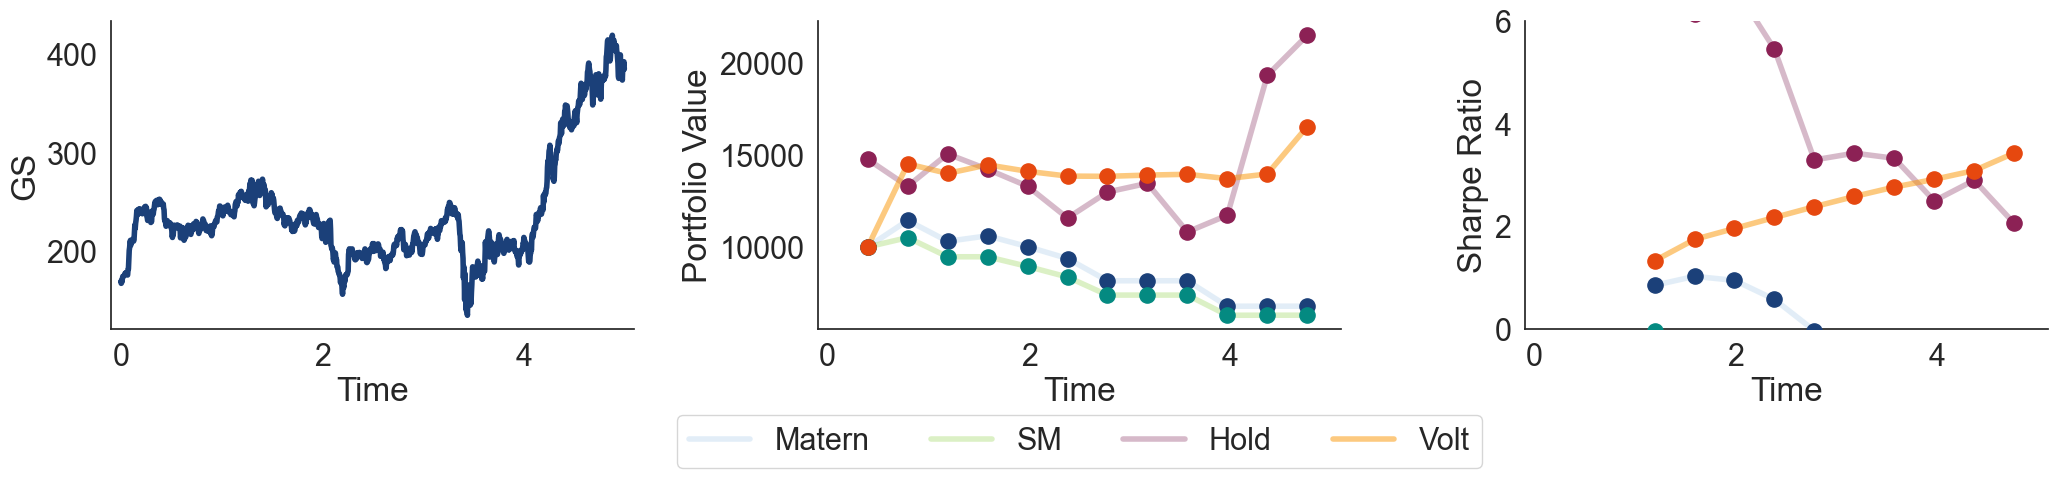

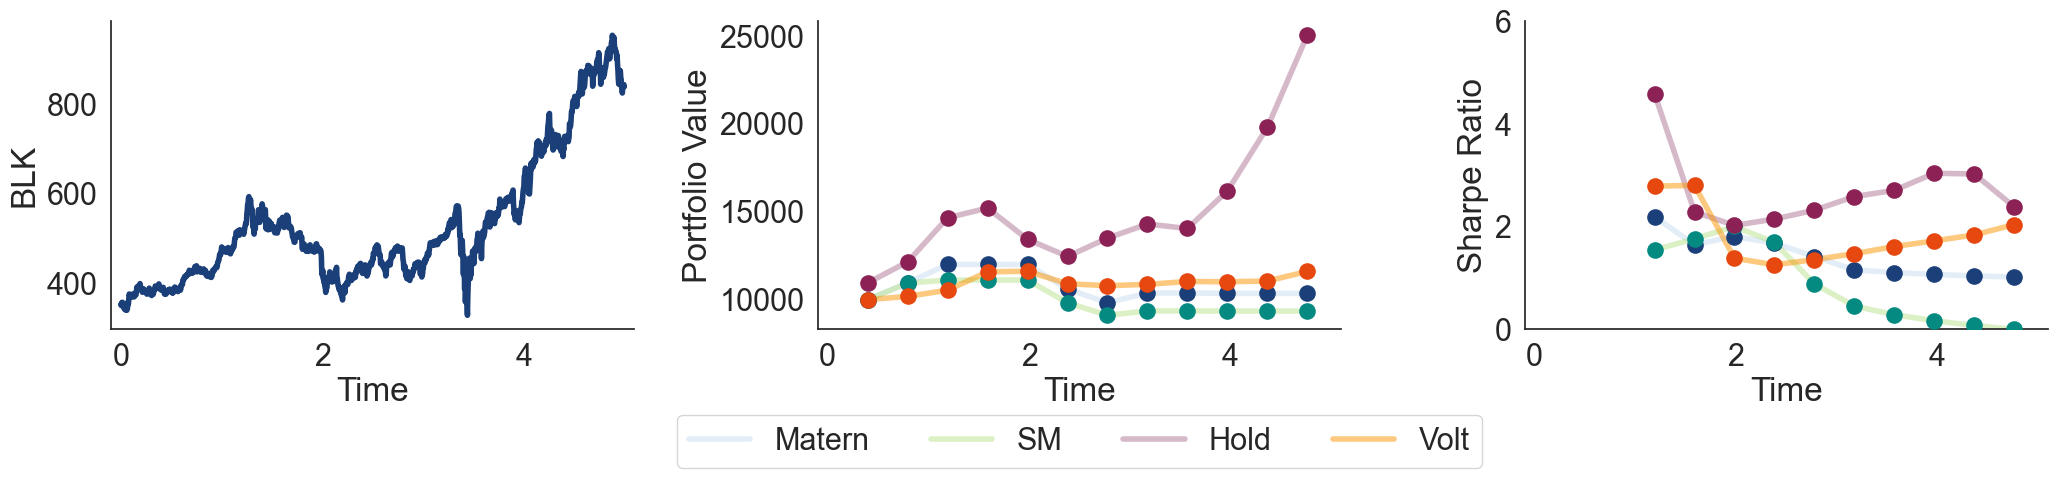

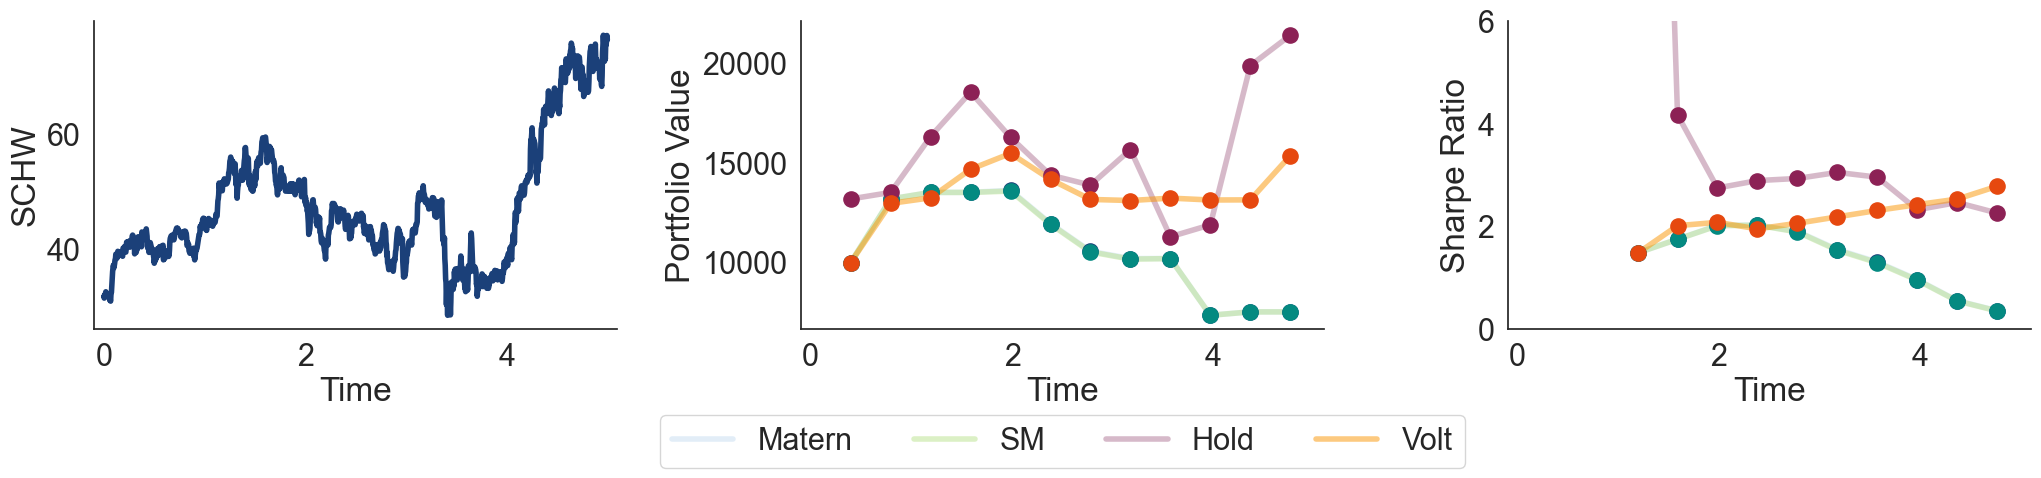

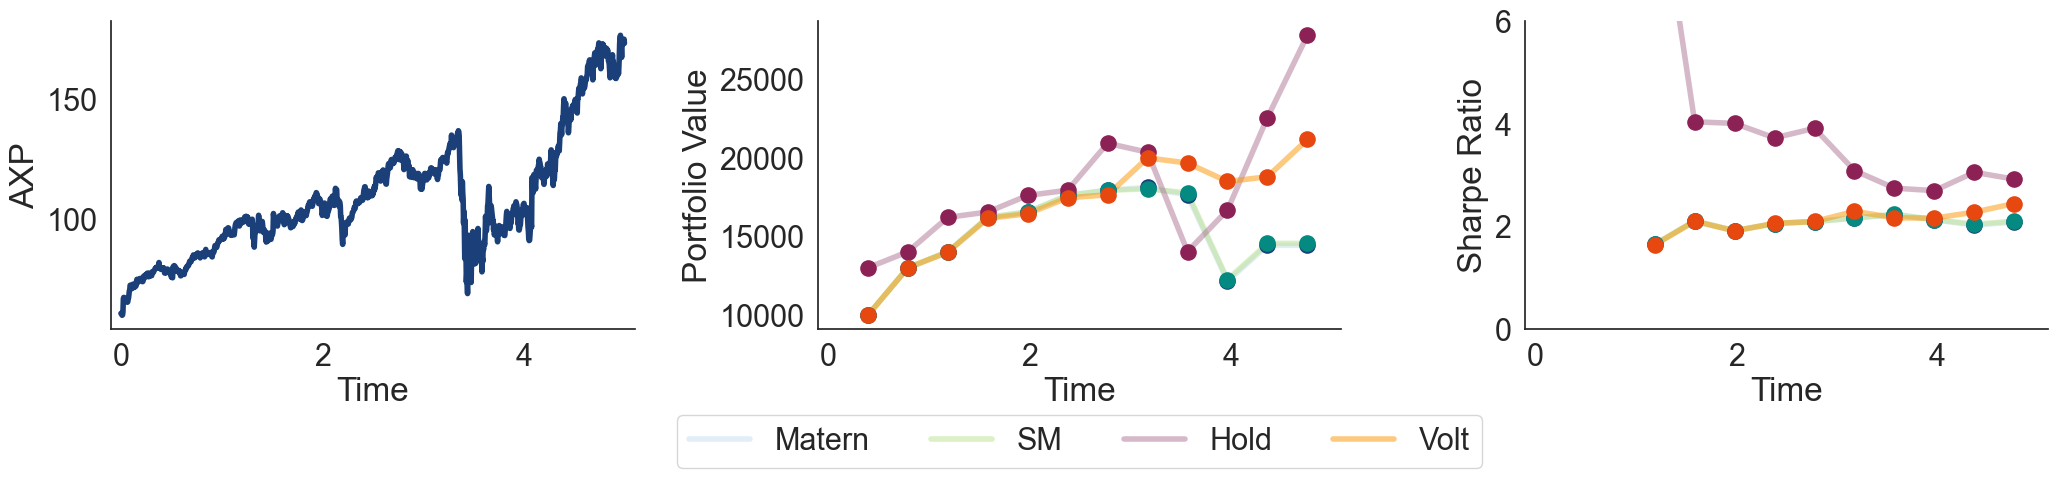

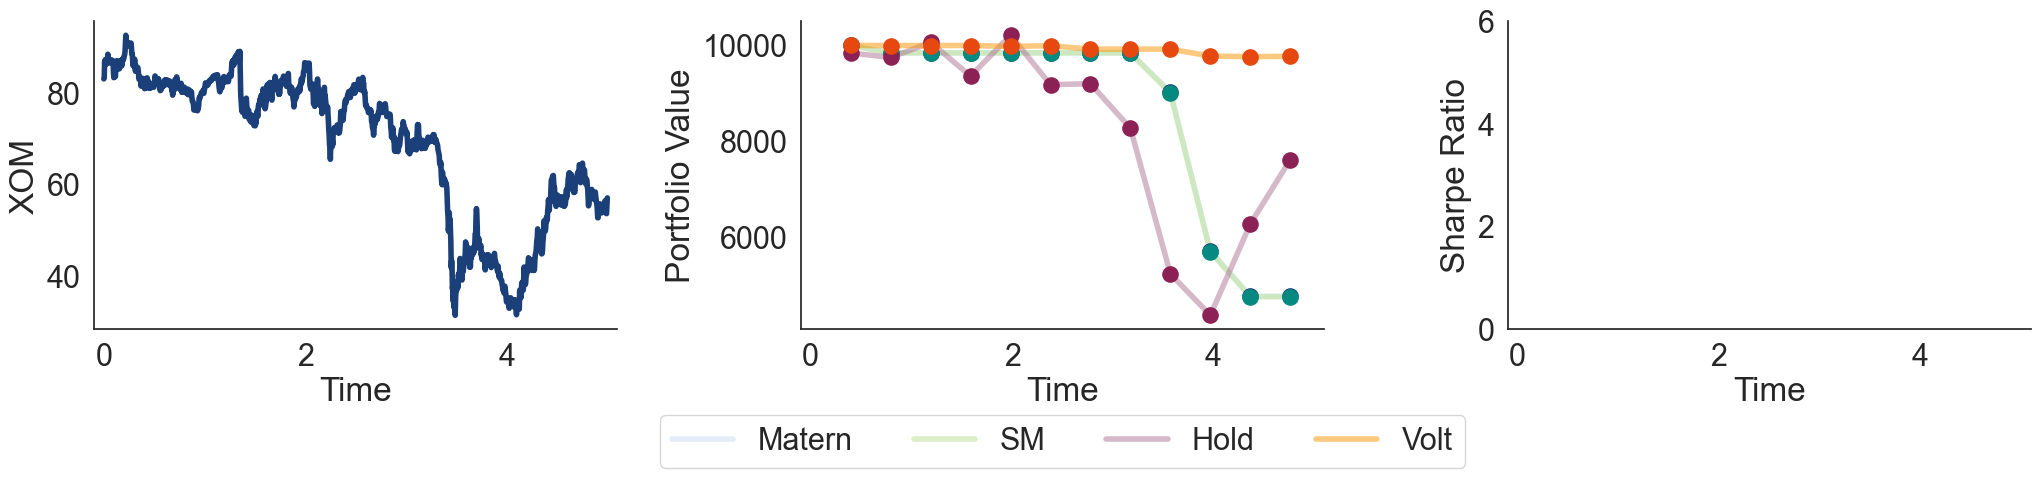

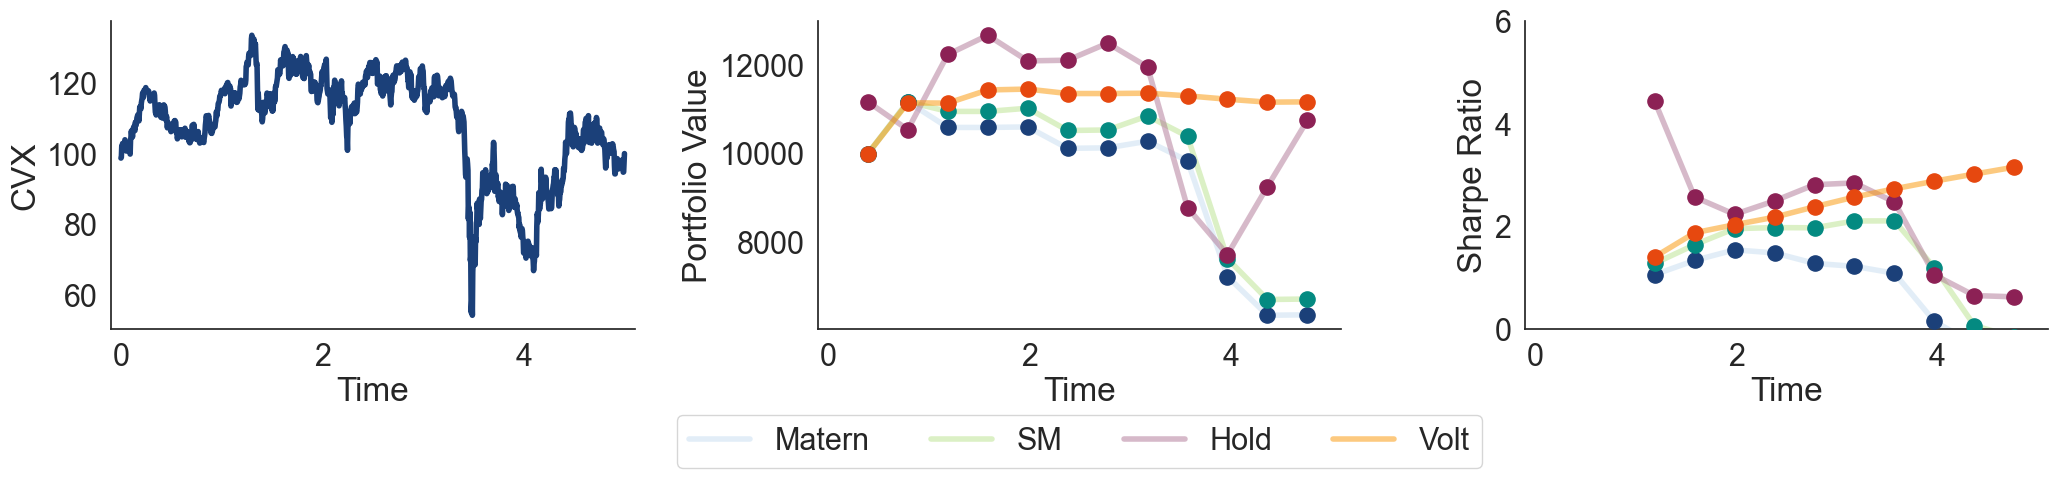

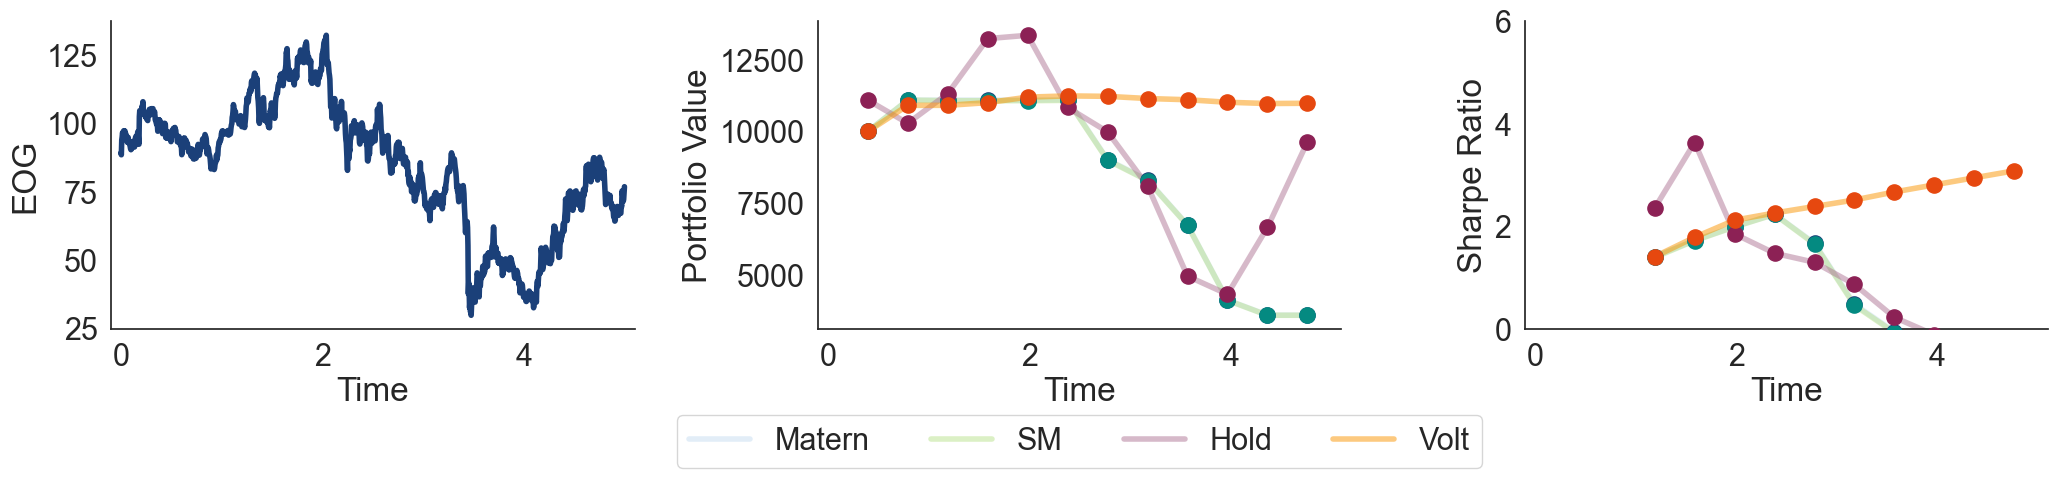

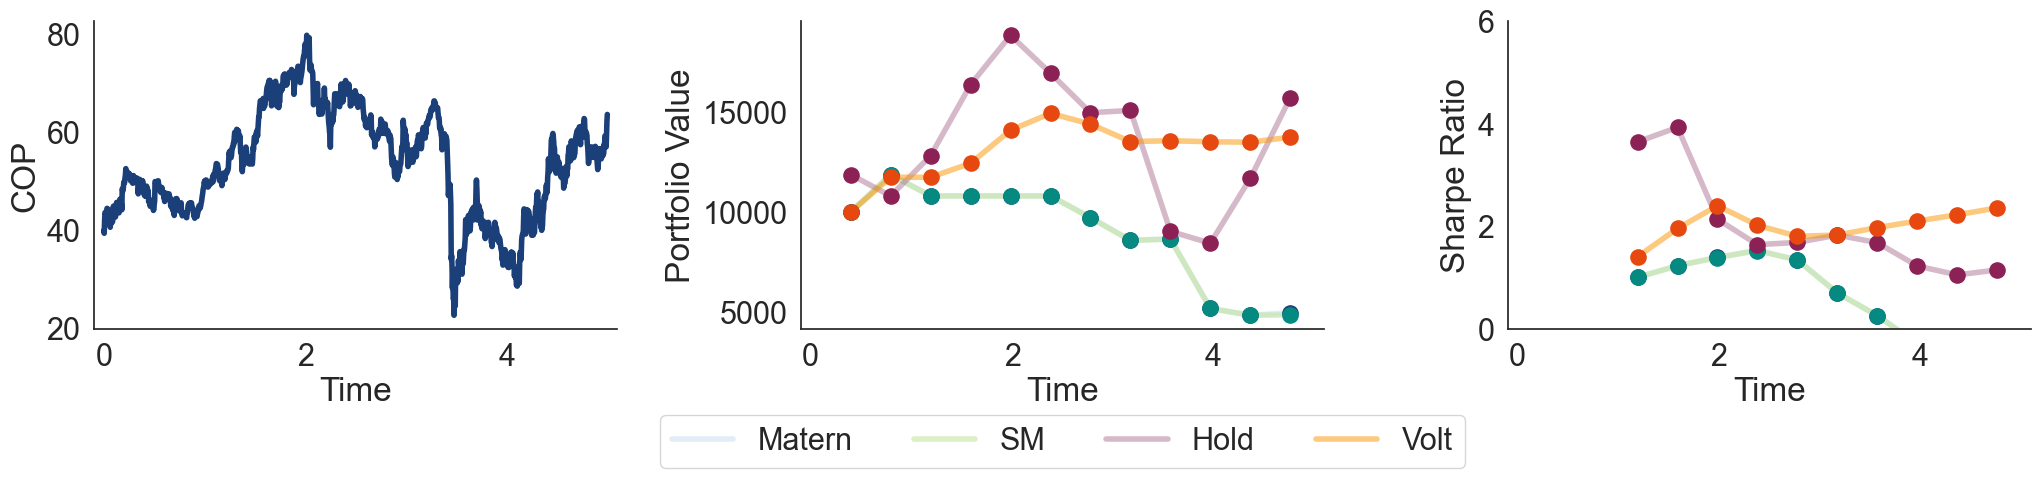

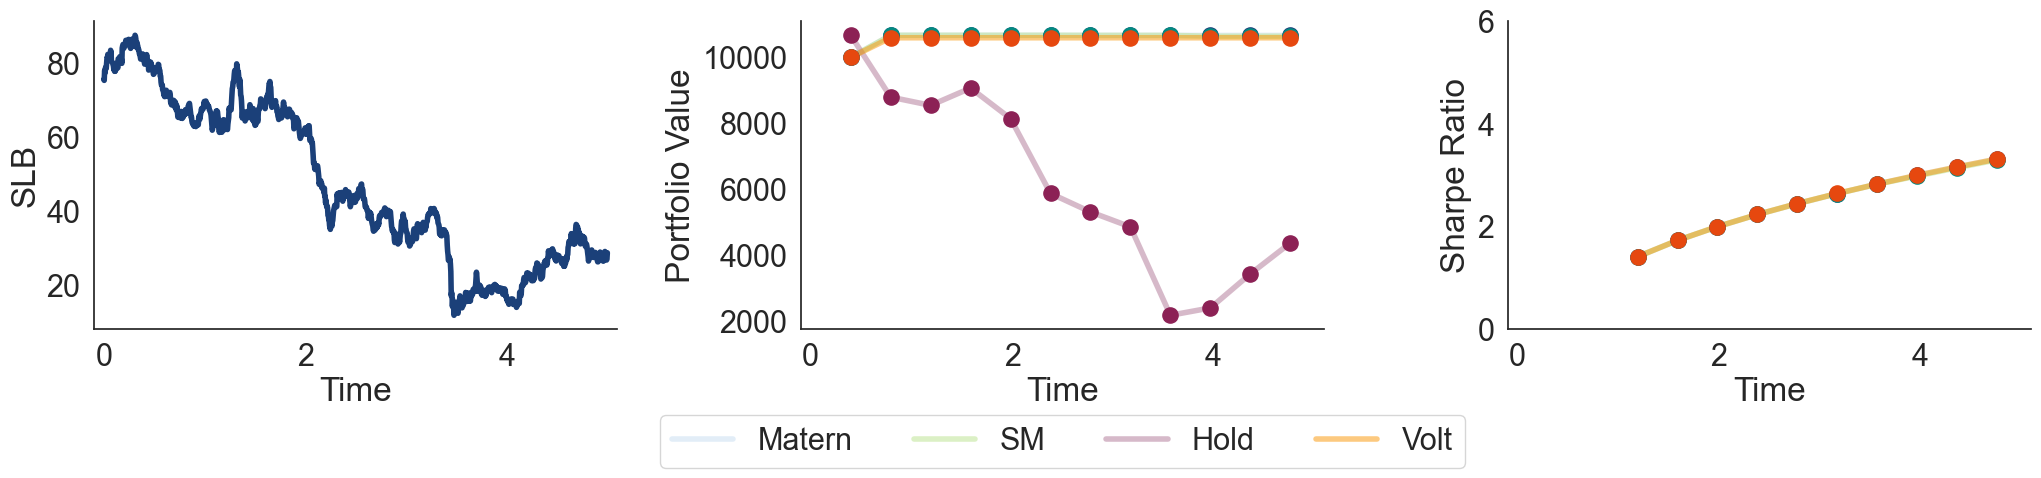

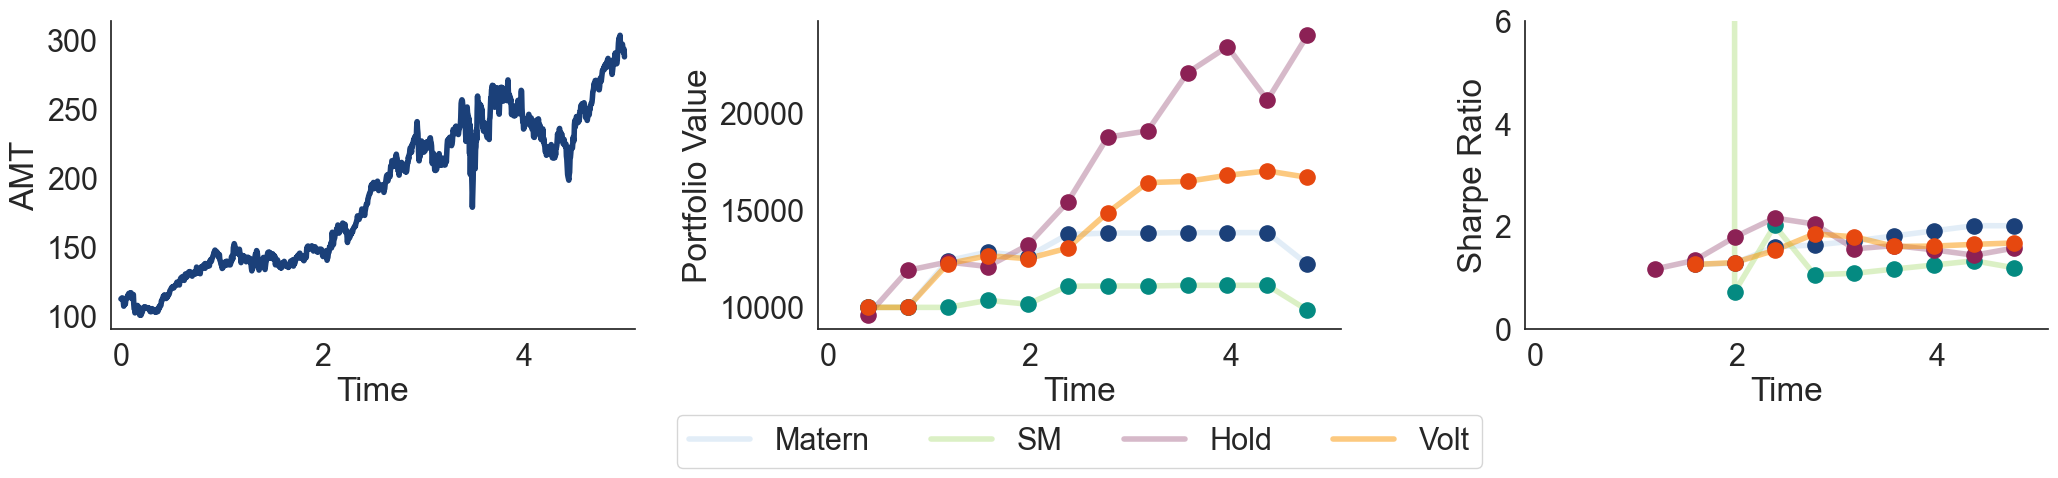

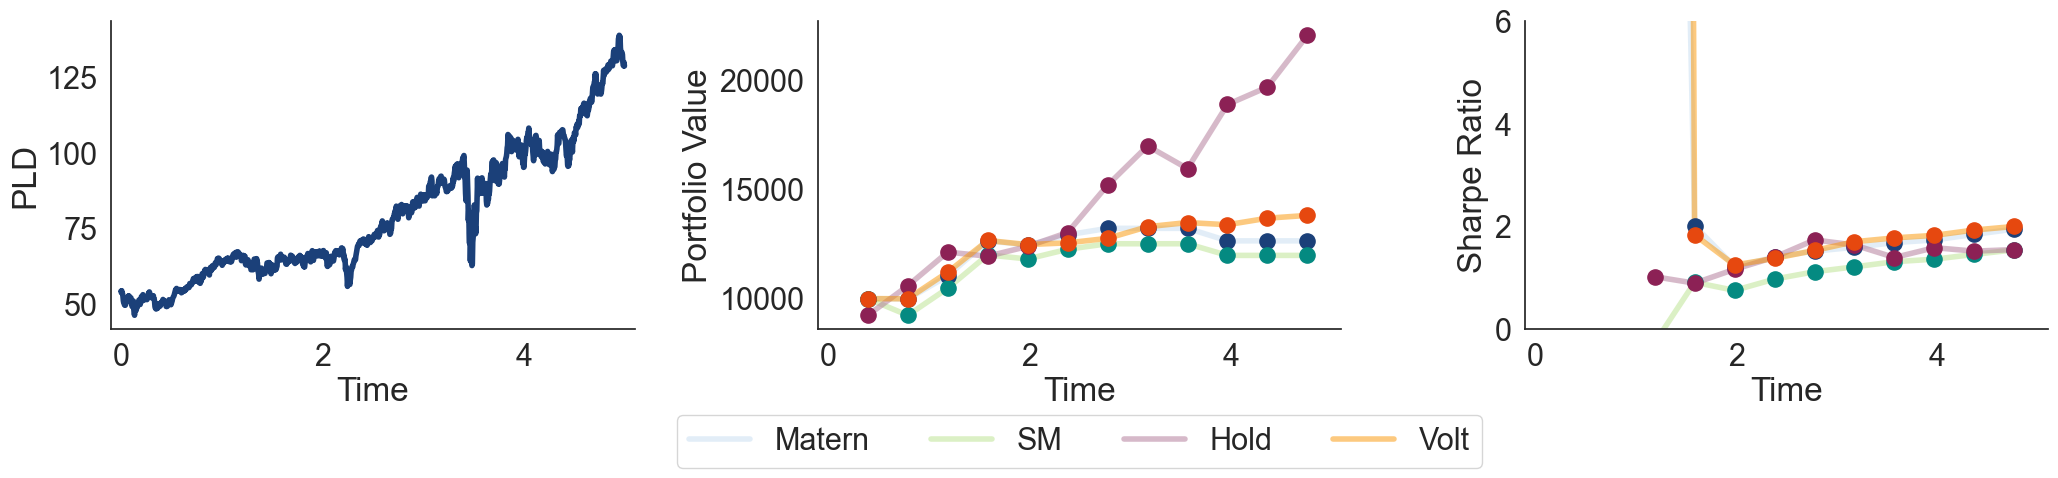

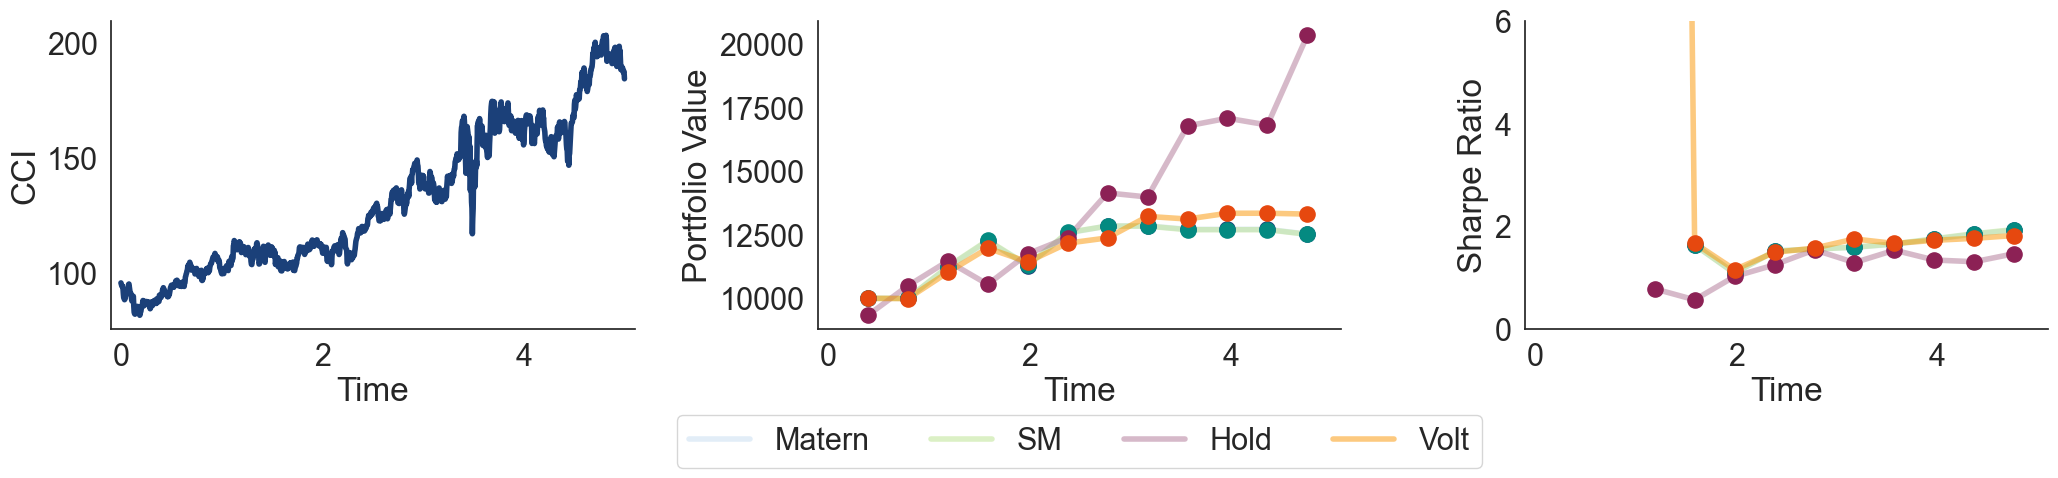

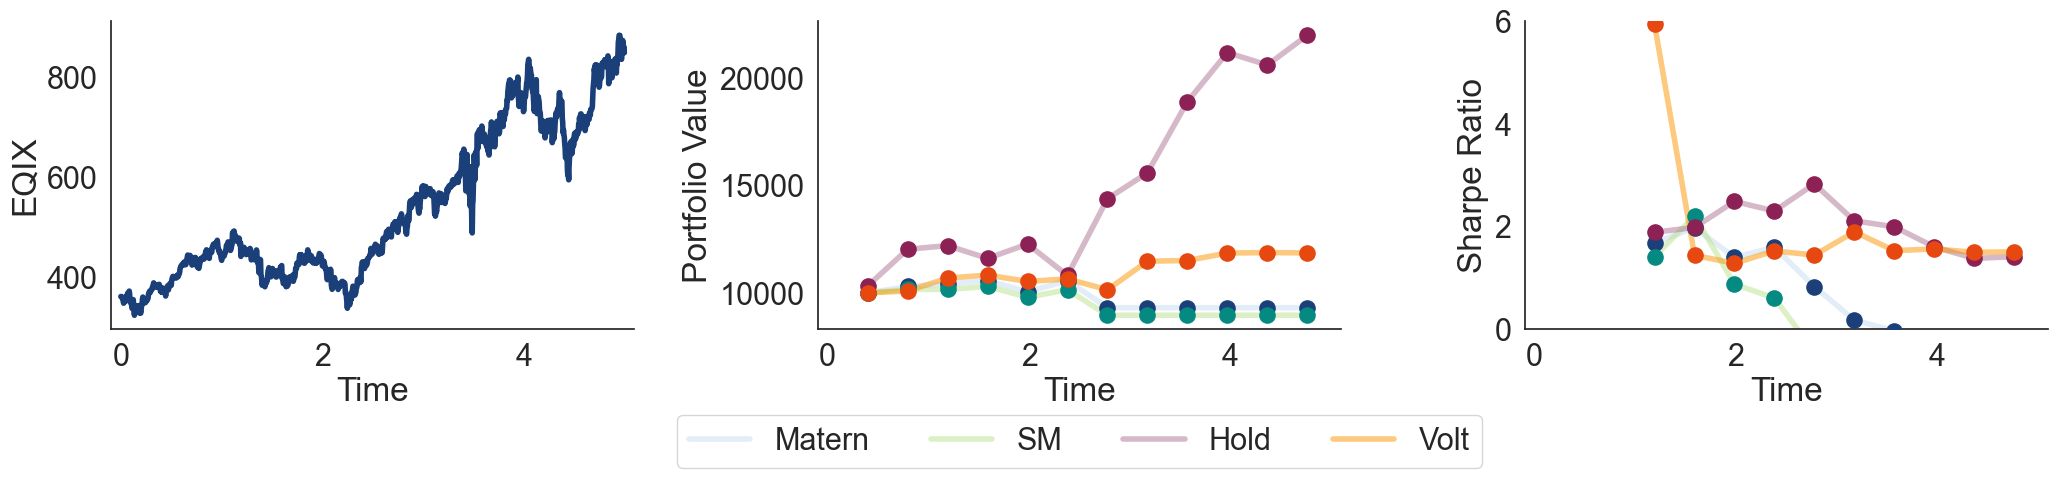

In [276]:
spdrs = ["XLF", "XLE", "XLRE"]
tckr_spdrs = []
tckrs = []
for spdr in spdrs:
    spdr_dat = pd.read_pickle("../../spdr-data/" + spdr + ".pkl")
    syms = list(spdr_dat.symbol.unique())
    tckrs += syms
    tckr_spdrs += [spdr for _ in range(len(syms))]

for tckr, SPDR in zip(tckrs, tckr_spdrs):
    spdr_dat = pd.read_pickle("../../spdr-data/" + SPDR + ".pkl")    
    data = spdr_dat[spdr_dat["symbol"] == tckr]
    T = 5.
    ts = torch.linspace(0, T, data.shape[0])
    y = torch.FloatTensor(data['close_price'].to_numpy())

    eval_times = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]

    prices_at_time_y = y[torch.tensor(eval_times)]
    delta_y = prices_at_time_y[1:] - prices_at_time_y[:-1]

    ## Load Price Probabilities
    if os.path.exists("./outputs/matern_" + tckr + ".pt"):
        voltron = torch.load("./outputs/voltron_" + tckr + ".pt")
        matern = torch.load("./outputs/matern_" + tckr + ".pt")
        specmix = torch.load("./outputs/sm_" + tckr + ".pt")

        bought_func = lambda xs: betainc(17, 8, xs)
        held_voltron = 1000 * bought_func(voltron)
        held_matern = 1000 * bought_func(matern)
        held_specmix = 1000 * bought_func(specmix)

        base = 10000

        prices_at_time_y = torch.tensor([y[0], *prices_at_time_y])

        plt_times = torch.tensor(eval_times) / 252
        hodl_strat = 10000 / y[0] * prices_at_time_y[1:]

        fig, ax = plt.subplots(1, 3, figsize = (25, 4))
        ax[0].plot(ts, y)
        [ax[i].set_xlabel("Time") for i in range(3)]
        ax[0].set_ylabel(tckr)
        [ax[0].axvline(x=eval_times[i], alpha = 0.2, linestyle="--") for i in range(len(eval_times))]

        # ax[1].plot(plt_times, matern, label = "Matern", color=palette[1], alpha = 0.5)
        # ax[1].plot(plt_times, specmix, label = "Spectral Mixture", color=palette[3], alpha = 0.5)
        # ax[1].plot(plt_times, voltron, label = "Voltron", color = palette[-1], alpha = 0.5)
        # ax[1].scatter(plt_times, matern, s = 120, label = "Matern", color=palette[0], zorder=4)
        # ax[1].scatter(plt_times, specmix, s = 120, label = "Spectral Mixture", color=palette[2], zorder=4)
        # ax[1].scatter(plt_times, voltron, s = 120, label = "Voltron", color = palette[-2], zorder=4)

        ax[1].plot(plt_times, value_func(matern), label = "Matern", color=palette[1], alpha = 0.5)
        ax[1].plot(plt_times, value_func(specmix), label = "SM", color=palette[3], alpha = 0.5)
        ax[1].plot(plt_times, hodl_strat, label = "Hold", color=palette[5], alpha = 0.5)
        ax[1].plot(plt_times, value_func(voltron), label = "Voltron", color = palette[-1], alpha = 0.5)
        ax[1].scatter(plt_times, value_func(matern), color=palette[0], zorder=4, s=120)
        ax[1].scatter(plt_times, value_func(specmix), color=palette[2], zorder=4, s=120)
        ax[1].scatter(plt_times, hodl_strat,color=palette[4], zorder=4, s=120)
        ax[1].scatter(plt_times, value_func(voltron),color = palette[-2], zorder=4, s=120)

        ax[2].plot(plt_times, running_sharpe_ratio(value_func(matern)), 
               label = "Matern", color=palette[1], alpha = 0.5)
        ax[2].plot(plt_times, running_sharpe_ratio(value_func(specmix)), 
                   label = "SM", color=palette[3], alpha = 0.5)
        ax[2].plot(plt_times, running_sharpe_ratio(hodl_strat), label = "Hold", markersize = 20,
                  color=palette[5], alpha = 0.5)
        ax[2].plot(plt_times, running_sharpe_ratio(value_func(voltron)), 
                   label = "Volt", color = palette[-1], alpha = 0.5)
        ax[2].scatter(plt_times, running_sharpe_ratio(value_func(matern)), 
                   s = 120, color=palette[0], zorder=4)
        ax[2].scatter(plt_times, running_sharpe_ratio(value_func(specmix)), 
                   s = 120, color=palette[2], zorder=4)
        ax[2].scatter(plt_times, running_sharpe_ratio(hodl_strat),
                     s = 120, color = palette[4], zorder=4)
        ax[2].scatter(plt_times, running_sharpe_ratio(value_func(voltron)), 
                   s = 120, color = palette[-2], zorder=4)


        # ax[1].set_ylabel("P(increase)")
        ax[1].set_ylabel("Portfolio Value")
        ax[2].set_ylabel("Sharpe Ratio")

        ax[2].legend(ncol = 4, loc = "lower center", bbox_to_anchor = (-0.85, -0.5))
        plt.subplots_adjust(wspace=0.35)
        sns.despine()
#         if tckr in ["JPM", "BAC"]:
        ax[2].set_ylim(0, 6)
        [ax[i].set_xlim((-0.1, 5.1)) for i in range(3)]
#         plt.savefig("trading_strategy_" + tckr + ".pdf", bbox_inches = "tight")
        plt.show()

In [246]:
value_func(matern)

tensor([10000.0000,  9132.0801,  9147.9814,  8791.2256,  8932.3867,  9046.4463,
        10762.1602, 10762.1602, 10762.1602, 10762.1602, 10762.1602, 10762.1602])

In [239]:
SPDR

'XLE'

In [278]:
tckr = "EOG"
SPDR = "XLE"
spdr_dat = pd.read_pickle("../../spdr-data/" + SPDR + ".pkl")    
data = spdr_dat[spdr_dat["symbol"] == tckr]
T = 5.
ts = torch.linspace(0, T, data.shape[0])
y = torch.FloatTensor(data['close_price'].to_numpy())

eval_times = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]

prices_at_time_y = y[torch.tensor(eval_times)]
delta_y = prices_at_time_y[1:] - prices_at_time_y[:-1]

## Load Price Probabilities

voltron = torch.load("./outputs/voltron_" + tckr + ".pt")
matern = torch.load("./outputs/matern_" + tckr + ".pt")
specmix = torch.load("./outputs/sm_" + tckr + ".pt")

bought_func = lambda xs: betainc(17, 8, xs)
held_voltron = 1000 * bought_func(voltron)
held_matern = 1000 * bought_func(matern)
held_specmix = 1000 * bought_func(specmix)

base = 10000

prices_at_time_y = torch.tensor([y[0], *prices_at_time_y])

plt_times = torch.tensor(eval_times) / 252
hodl_strat = 10000 / y[0] * prices_at_time_y[1:]

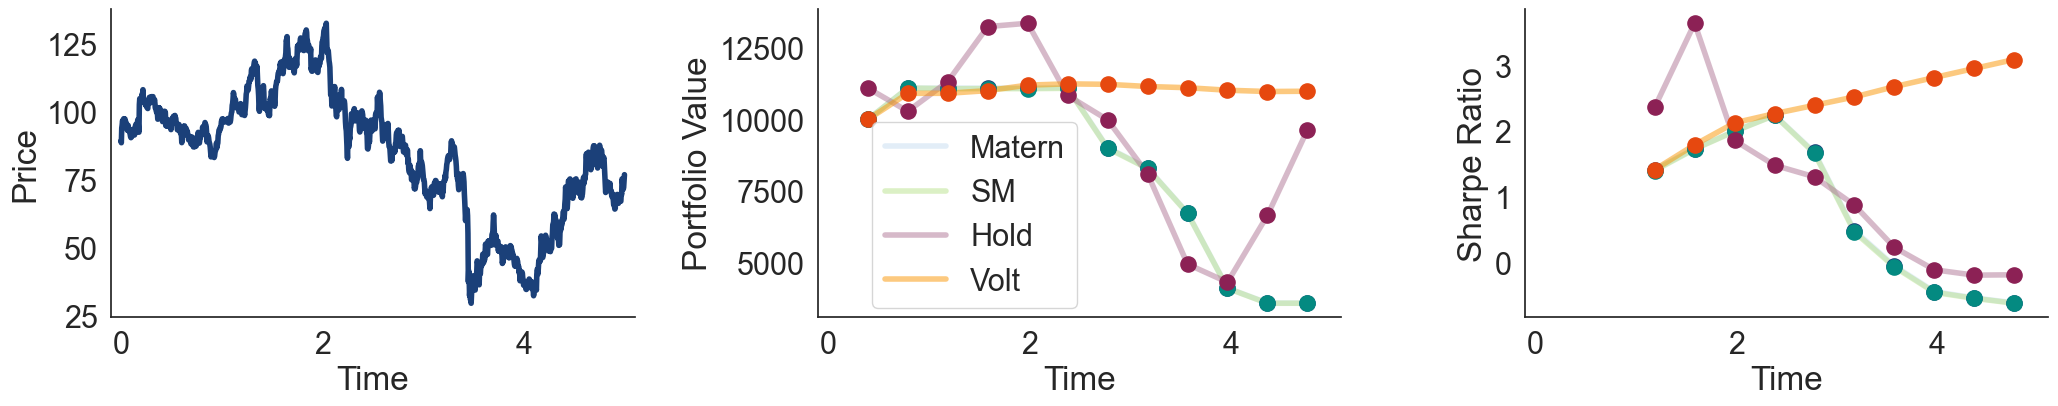

In [280]:
fig, ax = plt.subplots(1, 3, figsize = (25, 4))
ax[0].plot(ts, y)
[ax[i].set_xlabel("Time") for i in range(3)]
ax[0].set_ylabel("Price")
[ax[0].axvline(x=eval_times[i], alpha = 0.2, linestyle="--") for i in range(len(eval_times))]

# ax[1].plot(plt_times, matern, label = "Matern", color=palette[1], alpha = 0.5)
# ax[1].plot(plt_times, specmix, label = "Spectral Mixture", color=palette[3], alpha = 0.5)
# ax[1].plot(plt_times, voltron, label = "Voltron", color = palette[-1], alpha = 0.5)
# ax[1].scatter(plt_times, matern, s = 120, label = "Matern", color=palette[0], zorder=4)
# ax[1].scatter(plt_times, specmix, s = 120, label = "Spectral Mixture", color=palette[2], zorder=4)
# ax[1].scatter(plt_times, voltron, s = 120, label = "Voltron", color = palette[-2], zorder=4)

ax[1].plot(plt_times, value_func(matern), label = "Matern", color=palette[1], alpha = 0.5)
ax[1].plot(plt_times, value_func(specmix), label = "SM", color=palette[3], alpha = 0.5)
ax[1].plot(plt_times, hodl_strat, label = "Hold", color=palette[5], alpha = 0.5)
ax[1].plot(plt_times, value_func(voltron), label = "Volt", color = palette[-1], alpha = 0.5)
ax[1].scatter(plt_times, value_func(matern), color=palette[0], zorder=4, s=120)
ax[1].scatter(plt_times, value_func(specmix), color=palette[2], zorder=4, s=120)
ax[1].scatter(plt_times, hodl_strat,color=palette[4], zorder=4, s=120)
ax[1].scatter(plt_times, value_func(voltron),color = palette[-2], zorder=4, s=120)

ax[2].plot(plt_times, running_sharpe_ratio(value_func(matern)), 
       label = "Matern", color=palette[1], alpha = 0.5)
ax[2].plot(plt_times, running_sharpe_ratio(value_func(specmix)), 
           label = "SM", color=palette[3], alpha = 0.5)
ax[2].plot(plt_times, running_sharpe_ratio(hodl_strat), label = "Hold", markersize = 20,
          color=palette[5], alpha = 0.5)
ax[2].plot(plt_times, running_sharpe_ratio(value_func(voltron)), 
           label = "Volt", color = palette[-1], alpha = 0.5)
ax[2].scatter(plt_times, running_sharpe_ratio(value_func(matern)), 
           s = 120, color=palette[0], zorder=4)
ax[2].scatter(plt_times, running_sharpe_ratio(value_func(specmix)), 
           s = 120, color=palette[2], zorder=4)
ax[2].scatter(plt_times, running_sharpe_ratio(hodl_strat),
             s = 120, color = palette[4], zorder=4)
ax[2].scatter(plt_times, running_sharpe_ratio(value_func(voltron)), 
           s = 120, color = palette[-2], zorder=4)


# ax[1].set_ylabel("P(increase)")
ax[1].set_ylabel("Portfolio Value")
ax[2].set_ylabel("Sharpe Ratio")

ax[2].legend(ncol = 1, loc = "lower center", bbox_to_anchor = (-1.05, -0.02))
plt.subplots_adjust(wspace=0.35)
sns.despine()
if tckr in ["JPM", "BAC"]:
    ax[2].set_ylim(0, 6)
[ax[i].set_xlim((-0.1, 5.1)) for i in range(3)]
plt.savefig("trade_strat.pdf", bbox_inches = "tight")
plt.show()

In [185]:
SPDR = "XLRE"
spdr_dat = pd.read_pickle("../../spdr-data/" + SPDR + ".pkl")    

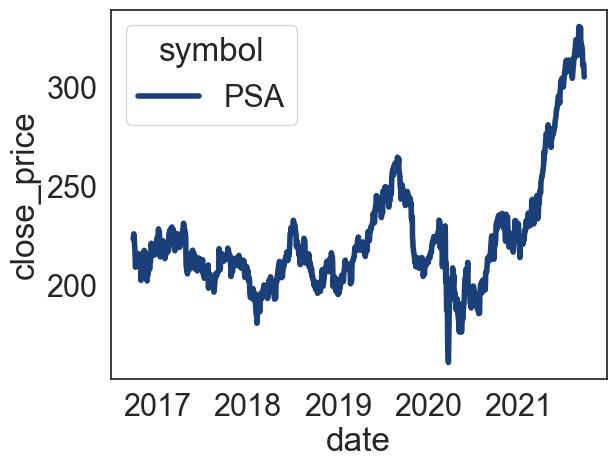

In [187]:
sns.lineplot(x="date", y="close_price", data=spdr_dat[spdr_dat.symbol == "PSA"], hue="symbol")
plt.show()